# Breakpoint
https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/

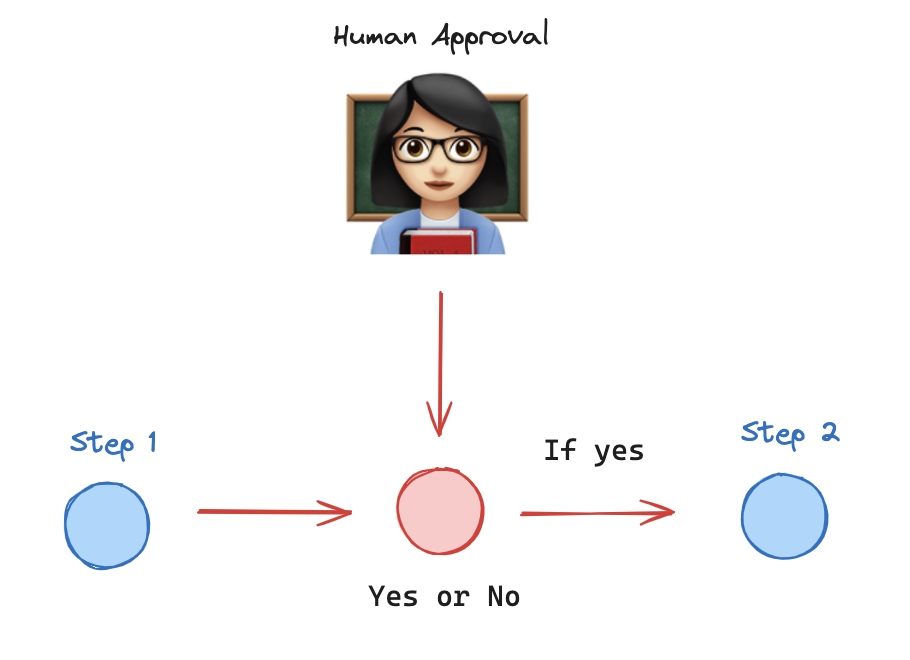!

In [2]:
import boto3

In [3]:
!pip3 install langchain-aws langchain-community langchain --quiet

In [4]:
from botocore.config import Config
from langchain_aws import ChatBedrock
bedrock_region = 'us-east-1'
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
boto3_bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=bedrock_region,
    config=Config(
        retries = {
            'max_attempts': 30
        }            
    )
)

HUMAN_PROMPT = "\n\nHuman:"
AI_PROMPT = "\n\nAssistant:"
maxOutputTokens = 4096
parameters = {
    "max_tokens":maxOutputTokens,     
    "temperature":0.1,
    "top_k":250,
    "top_p":0.9,
    "stop_sequences": [HUMAN_PROMPT]
}    
chat = ChatBedrock(   
    model_id=modelId,
    client=boto3_bedrock, 
    model_kwargs=parameters,
)

In [7]:
from langchain.memory import ConversationBufferWindowMemory
memory_chain = ConversationBufferWindowMemory(memory_key="chat_history", output_key='answer', return_messages=True, k=10)

In [12]:
import getpass
import os

In [10]:
langsmith_api_key = getpass.getpass("Password:")

Password: ········


In [13]:
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "breakpoints"

## Simple Usage

In [28]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
    input: str

def step_1(state):
    print("---Step 1---")
    pass

def step_2(state):
    print("---Step 2---")
    pass

def step_3(state):
    print("---Step 3---")
    pass

workflow = StateGraph(State)
workflow.add_node("step_1", step_1)
workflow.add_node("step_2", step_2)
workflow.add_node("step_3", step_3)
workflow.add_edge(START, "step_1")
workflow.add_edge("step_1", "step_2")
workflow.add_edge("step_2", "step_3")
workflow.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add 
graph = workflow.compile(checkpointer=memory, interrupt_before=["step_3"])

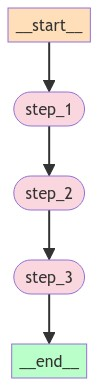

In [29]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

user_approval = input("Do you want to go to Step 3? (yes/no): ")

if user_approval.lower() == 'yes':
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        print(event)
else:
    print("Operation cancelled by user.")

{'input': 'hello world'}
---Step 1---
---Step 2---


Do you want to go to Step 3? (yes/no):  yes


---Step 3---


## Agent

In [18]:
from langchain_core.tools import tool
from langgraph.graph import MessagesState, START
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

In [19]:
@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return [
        "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    ]

In [20]:
tools = [search]
tool_node = ToolNode(tools)

In [22]:
# Set up the model

model = chat.bind_tools(tools)

In [23]:
# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

In [30]:
# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [32]:
# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Set up memory
memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable

# We add in `interrupt_before=["action"]`
# This will add a breakpoint before the `action` node is called
app = workflow.compile(checkpointer=memory, interrupt_before=["action"])

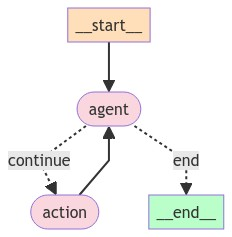

In [33]:
display(Image(app.get_graph().draw_mermaid_png()))

## Interacting with the Agent

In [25]:
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "3"}}
inputs = [HumanMessage(content="search for the weather in sf now")]
for event in app.stream({"messages": inputs}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

search for the weather in sf now
================================== Ai Message ==================================
Tool Calls:
  search (toolu_bdrk_01KJqMCKm1nd7ej6w3xayBSy)
 Call ID: toolu_bdrk_01KJqMCKm1nd7ej6w3xayBSy
  Args:
    query: san francisco weather


## Resume

In [26]:
for event in app.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: search

["It's sunny in San Francisco, but you better look out if you're a Gemini \ud83d\ude08."]
================================== Ai Message ==================================

The search results show the current weather conditions in San Francisco. It looks like it is sunny there right now. However, the results also include a humorous astrological warning for people with the Gemini zodiac sign, which doesn't seem directly relevant to the weather query.

To summarize the key information from the search:

The current weather in San Francisco is sunny.
